In [1]:
import glob
import os
import pandas as pd
# Numpy for numpy.arrays
import numpy as np

# Include ITK for DICOM reading.
import itk

# Include pydicom_seg for DICOM SEG objects
import pydicom
import pydicom_seg

# for downloading data from TCIA
from tcia_utils import nbia

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# imports for monai
import torch
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download
from monai.config import print_config

import SimpleITK as sitk
import nibabel as nib
import tqdm


2024-03-13 09:35:41,045:WARNING:From c:\Users\Joel Fischer\.conda\envs\segmentationenv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
#import the pirads file and change the rownames:
pirads = pd.read_excel('Pirads.xlsx')
pirads.rename(columns={'Unnamed: 0': 'lesion_name'},inplace=True)
pirads.index = list(pirads['lesion_name'])
pirads.drop('lesion_name',axis=1,inplace=True)

In [3]:
translation = pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\translation.xlsx')
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
translation.drop(8,inplace=True) #remove the bell_0027 case as its metadata is missing. 



In [4]:
#Goal: calculate the Gleason score between the three readers when using manual and assisted segmentation.
#Difficulty: many lesions are not seen by all readers:
# First, compare for Reader 1,2,3 the DSC between all lesions they saw in manual and assisted segmentation:


In [5]:
def DICE_COE(segmentation_A, segmentation_B):
    # segmentation_A: lesion mask of a lesion
    # segmentation_A: lesion mask of a different lesion
    intersection = np.sum(segmentation_A*segmentation_B)
    fsum = np.sum(segmentation_A)
    ssum = np.sum(segmentation_B)
    dice = (2 * intersection) / (fsum + ssum)
    dice = round(dice, 3)
    return (dice)    

In [6]:
#write a script which returns the DSC between two segmentations as a list:
#key test if lesion volumes are calculated correctly.

def DSCs_for_one_lesion(pirads_lesion,lesion_name, folder, column_name):
    # pirads_lesion: The original table with lesion data cut to only the entries of this lesion
    # lesion name: na e of the current lesion: e.g les-0
    # folder: place of the saved niffti files
    # column_name: the column of the lesion we want to calculate the DSC of.

    seg_reader = pydicom_seg.MultiClassReader()

    Case = pirads_lesion.iloc[0,0]
    new_casename = pirads_lesion.iloc[0,0].split('_')[0] + '-' + pirads_lesion.iloc[0,0].split('_')[1]


    lesion_A_annotator = column_name.split('_')[0]
    lesion_A_annotation_type = column_name.split('_')[1]
    lesion_A_rowname = Case + '_' + lesion_name + '_' + lesion_A_annotator + '_' + lesion_A_annotation_type + '_t2w'

    lesion_B_annotator = column_name.split('_')[3]
    lesion_B_annotation_type = column_name.split('_')[4]
    lesion_B_rowname = Case + '_' + lesion_name + '_' + lesion_B_annotator + '_' + lesion_B_annotation_type + '_t2w'

    if lesion_A_rowname in pirads_lesion.index and lesion_B_rowname in pirads_lesion.index:
        filename_segA = folder + '\\' + new_casename + '_t2w_' + lesion_name + '--p-' +  str(pirads_lesion.loc[lesion_A_rowname,'PIRADS']) + '--g-0_' + lesion_A_annotator + '_' + lesion_A_annotation_type + '.nii.gz'
        filename_segB = folder + '\\' + new_casename + '_t2w_' + lesion_name + '--p-' +  str(pirads_lesion.loc[lesion_B_rowname,'PIRADS']) + '--g-0_' + lesion_B_annotator + '_' + lesion_B_annotation_type + '.nii.gz'
        
        segmentation_A = nib.load(filename_segA)
        segmentation_B = nib.load(filename_segB)
        #segmentation_A = itk.imread(filename_segA, itk.F)
        #segmentation_B = itk.imread(filename_segB, itk.F)

        return(DICE_COE(segmentation_A.get_fdata(),segmentation_B.get_fdata()))

    else:
        return('no_score')
                


In [7]:
def number_lesions_Case(pirads,Case):
    pirads_patient = pirads[pirads['Case'] == Case]
    number_lesions = 0
    liste = []
    for i in pirads_patient.index:
        number = int(pirads_patient.loc[i,'Content'].split('-')[1])
        liste.append(number)
    return(max(liste) + 1)

In [8]:
DSC_colnames = ['rad1_rad_vs_rad1_ass',

                'rad1_rad_vs_rad2_rad',
                'rad1_rad_vs_rad2_ass',
                'rad1_ass_vs_rad2_rad',
                'rad1_ass_vs_rad2_ass',

                'rad1_rad_vs_rad3_rad',
                'rad1_rad_vs_rad3_ass',
                'rad1_ass_vs_rad3_rad',
                'rad1_ass_vs_rad3_ass',

                'rad2_rad_vs_rad2_ass',

                'rad2_rad_vs_rad3_rad',
                'rad2_rad_vs_rad3_ass',
                'rad2_ass_vs_rad3_rad',
                'rad2_ass_vs_rad3_ass',

                'rad3_rad_vs_rad3_ass',
                ]
DSC_scores_lesionwise = pd.DataFrame(columns=DSC_colnames)

for Patient in list(translation['Case']):
    Case = Patient.split('_')[0] + '-' + Patient.split('_')[1]
    Site = Case.split('-')[0]
    folder = 'E:\\ksa_study_data\\' + Site + '\\' + Case

    #Get the number of lesions of this Case:

    try:
        lesion_numbers = number_lesions_Case(pirads,Patient)
    except:
        lesion_numbers = 0
        print('Case with no positive lesions: ' ,Patient)

    #only give the function the part of the pirads file it needs:
    pirads_patient = pirads[pirads['Case'] == Patient]
    #loop through the lesions of this patient:
    for lesion_number in range(0,lesion_numbers):
        lesion_name = 'les-' + str(lesion_number)
        pirads_lesion = pirads_patient[pirads_patient['Content'] == lesion_name]
        rowname = str(Patient) + '_les_' + str(lesion_number)
        DSC_scores_lesionwise.loc[rowname] = ''
        for column_name in DSC_scores_lesionwise.columns:
            DSC_scores_lesionwise.loc[rowname,column_name] = DSCs_for_one_lesion(pirads_lesion, lesion_name, folder, column_name)

Case with no positive lesions:  ksa3_0297
Case with no positive lesions:  ksa3_0410
Case with no positive lesions:  ksa3_0513
Case with no positive lesions:  ksa3_0734
Case with no positive lesions:  ksa3_0749
Case with no positive lesions:  ksa3_0879


In [9]:
#Maybe the lesion nomenclature should be based on the center of gravity of the segmentation:
#assign each lesion to the closest other lesion.

In [10]:
boxplot_table = pd.DataFrame(columns=['DSC_value','Reader1','Anntype1','Reader2','Anntype2','X_vs_X'])

#Create the boxplot table:
for lesion in DSC_scores_lesionwise.index:
    for column in DSC_scores_lesionwise.columns:
        if DSC_scores_lesionwise.loc[lesion,column] != 'no_score':
            Reader1 = column.split('_')[0]
            Annottype1 = column.split('_')[1]
            Reader2 = column.split('_')[3]
            Annottype2 =column.split('_')[4]

            if Annottype1 == 'ass' and Annottype2 == 'ass':
                X_vs_X = 'ass_vs_ass' 


            if (Annottype1 == 'ass' and Annottype2 == 'rad') or (Annottype1 == 'rad' and Annottype2 == 'ass'):
                X_vs_X = 'ass_vs_man' 


            if Annottype1 == 'rad' and Annottype2 == 'rad':
                X_vs_X = 'man_vs_man' 
      

            new_colname = lesion + '_' + Reader1 + '_' + Annottype1 + '_vs_' + Reader2 + '_' + Annottype2
            boxplot_table.loc[new_colname] = [DSC_scores_lesionwise.loc[lesion,column],Reader1,Annottype1,Reader2,Annottype2,X_vs_X]


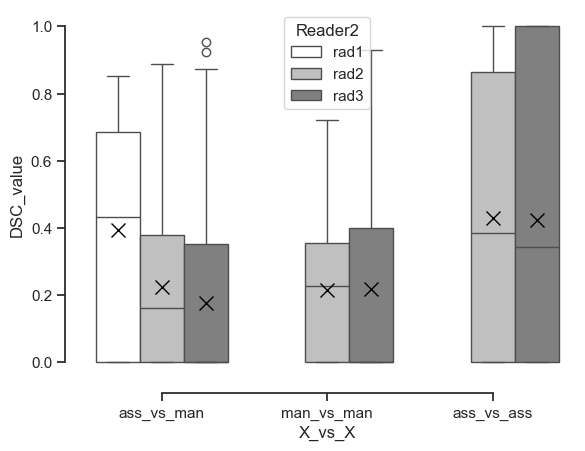

In [11]:
#plot the DSC scores as boxplots:

import seaborn as sns
from matplotlib import pyplot as plt
#Create boxplots:
sns.set_theme(style="ticks", palette="Greys")

sns.boxplot(x="X_vs_X", y="DSC_value",
            hue="Reader2", palette=["white",'silver', "grey"],whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},data=boxplot_table)
'''The boxplot shows the minimum, lower quartile, median, upper quartile and maximum for each metric. 
Outliers are shown as individual circles. The horzontal lines above and under the actual boxes extend 
to points within 1.5 inter quartile range of the upper and lower quartile.
Mean as crosses.'''


sns.despine(offset=10,trim=True)

Text(0.5, 0.98, 'DSC values of different readers and annotation types')

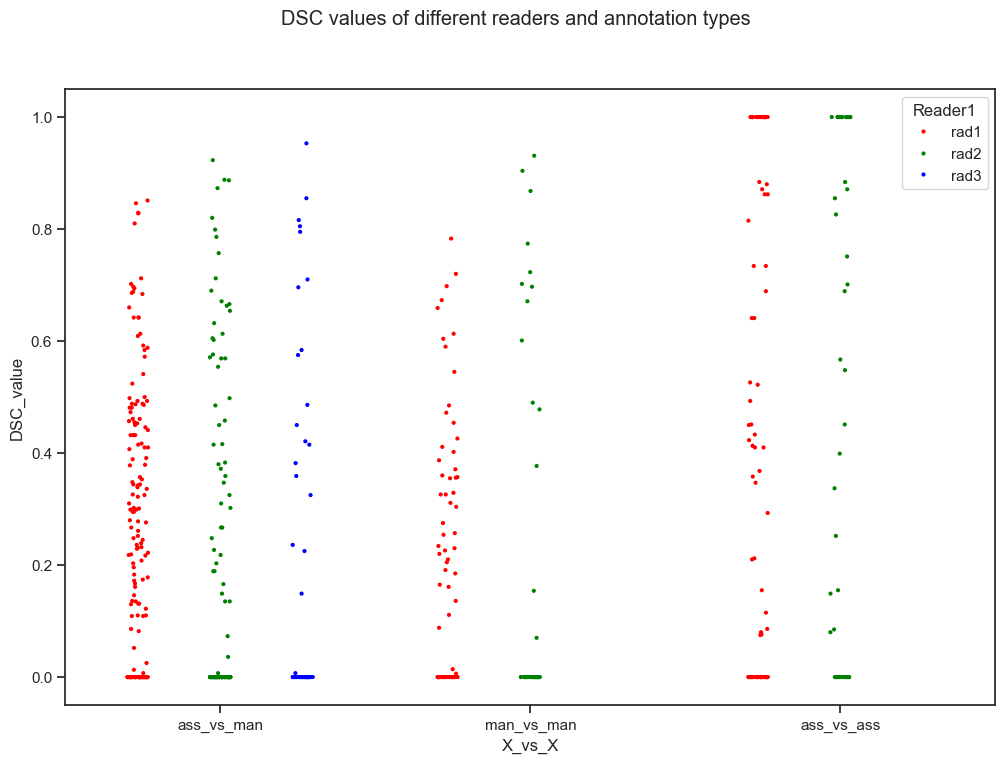

In [12]:
fig = plt.figure(figsize=(12,8))

sns.set_theme(style="ticks", palette="Greys")
sns.stripplot(data=boxplot_table, x="X_vs_X",palette=["red",'green', "blue"], y="DSC_value", hue="Reader1",size=3,dodge=True)
fig.suptitle('DSC values of different readers and annotation types')


FigureCanvasAgg is non-interactive, and thus cannot be shown


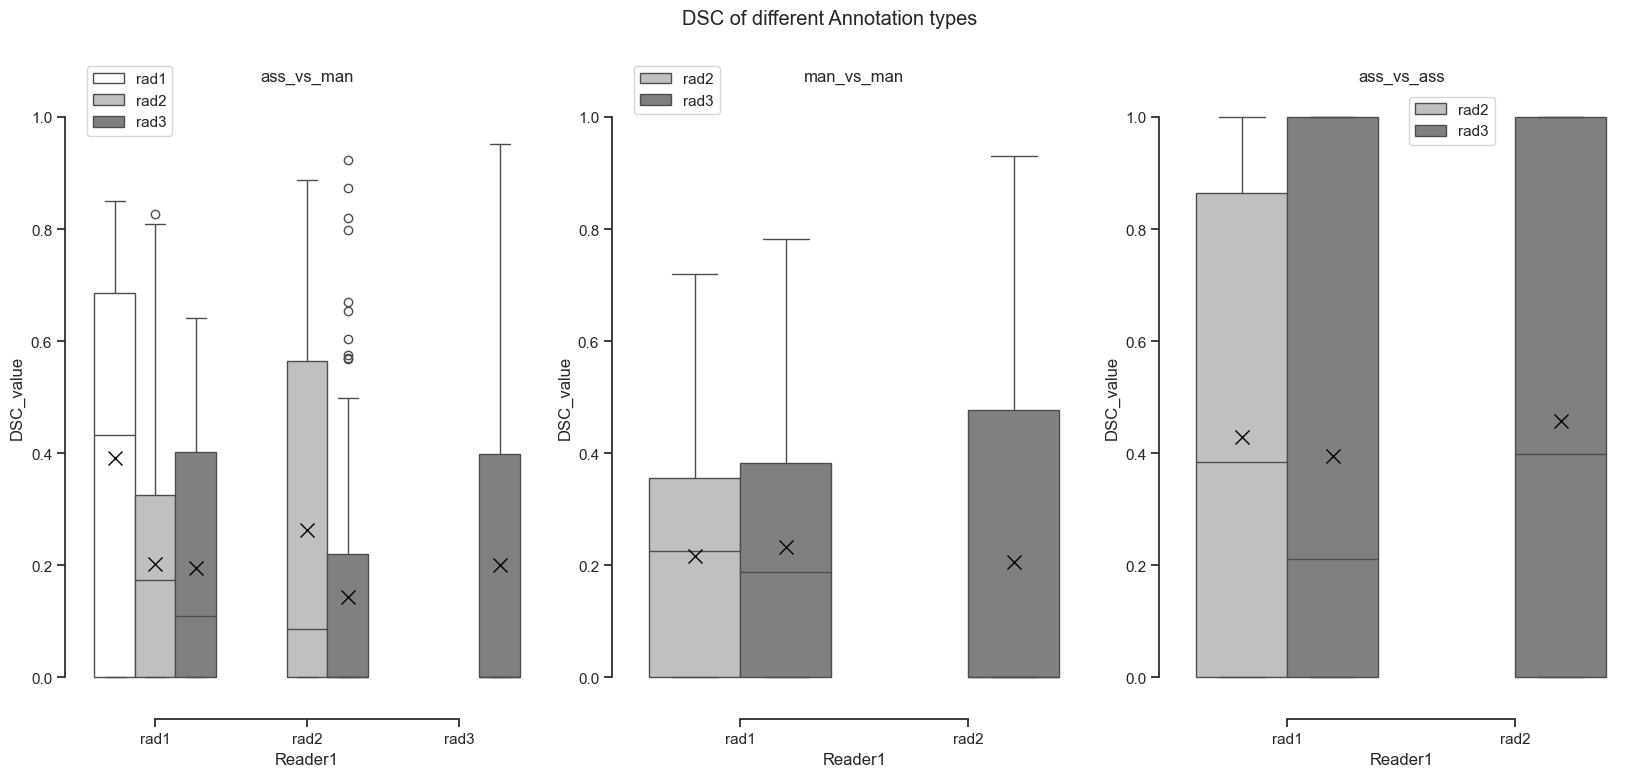

In [13]:
#plot the DSC scores as boxplots:

boxplot_table_ass_vs_man = boxplot_table[boxplot_table['X_vs_X'] == 'ass_vs_man']
boxplot_table_man_vs_man = boxplot_table[boxplot_table['X_vs_X'] == 'man_vs_man']
boxplot_table_ass_vs_ass = boxplot_table[boxplot_table['X_vs_X'] == 'ass_vs_ass']



import seaborn as sns
from matplotlib import pyplot as plt


fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,8),)

fig.suptitle('DSC of different Annotation types')
#Create boxplots:
sns.set_theme(style="ticks", palette="Greys")

ax1.set_title('ass_vs_man')
ax1 = sns.boxplot(ax = ax1, x="Reader1", y="DSC_value",
            hue="Reader2", palette=["white",'silver', "grey"],whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},data=boxplot_table_ass_vs_man)
'''The boxplot shows the minimum, lower quartile, median, upper quartile and maximum for each metric. 
Outliers are shown as individual circles. The horzontal lines above and under the actual boxes extend 
to points within 1.5 inter quartile range of the upper and lower quartile.
Mean as crosses.'''
ax1.set_ylim([-0.05, 1.05])
ax1.legend(bbox_to_anchor=(0, 1.05), loc='upper left')

ax2.set_title('man_vs_man')
ax2 = sns.boxplot(ax = ax2,x="Reader1", y="DSC_value",
            hue="Reader2", palette=['silver', "grey"],whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},data=boxplot_table_man_vs_man)
ax2.set_ylim([-0.05, 1.05])
ax2.legend(bbox_to_anchor=(0, 1.05), loc='upper left')
ax3.set_title('ass_vs_ass')

sns.boxplot(ax = ax3, x="Reader1", y="DSC_value",
            hue="Reader2", palette=['silver', "grey"],whis=1.5,showmeans=True,
                        meanprops={"marker":"x",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},data=boxplot_table_ass_vs_ass)
#ax3.get_yaxis().set_visible(False)
ax3.set_ylim([-0.05, 1.05])
ax3.legend(bbox_to_anchor=(0.5, 1.00), loc='upper left')

fig.show()
sns.despine(offset=10,trim=True)

FigureCanvasAgg is non-interactive, and thus cannot be shown


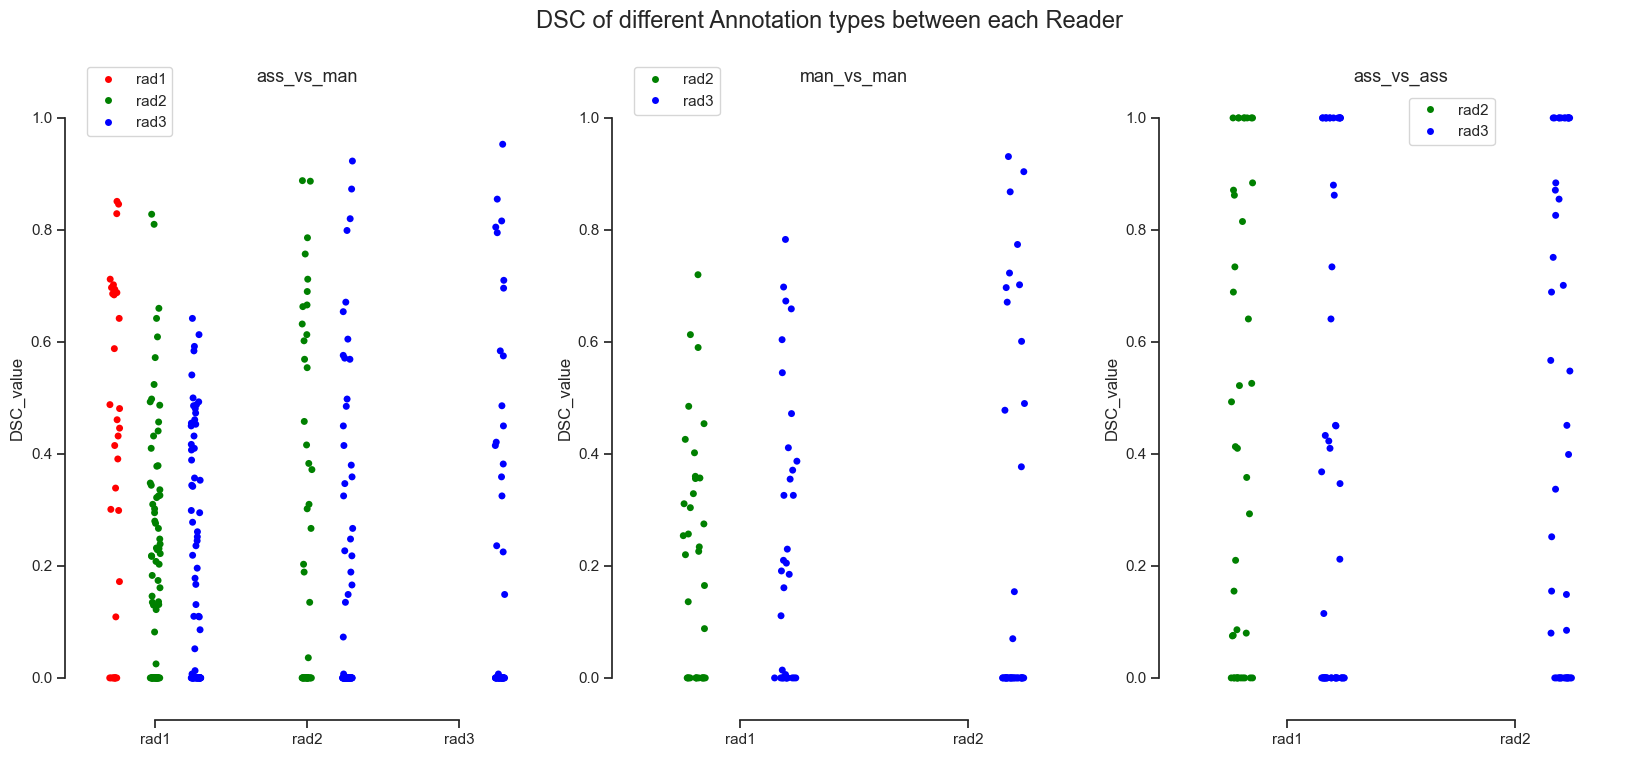

In [16]:
#plot the DSC scores as stripplot, as the boxes get way too large due to many 0 and 1 values:

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,8),)

fig.suptitle('DSC of different Annotation types between each Reader',size=17)
#Create boxplots:
sns.set_theme(style="ticks", palette="Greys")

ax1.set_title('ass_vs_man',size=13)
ax1 = sns.stripplot(ax = ax1, x="Reader1", y="DSC_value",
            hue="Reader2", palette=["red",'green', "blue"], data=boxplot_table_ass_vs_man, dodge=True)
'''The boxplot shows the minimum, lower quartile, median, upper quartile and maximum for each metric. 
Outliers are shown as individual circles. The horzontal lines above and under the actual boxes extend 
to points within 1.5 inter quartile range of the upper and lower quartile.
Mean as crosses.'''
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('')
ax1.legend(bbox_to_anchor=(0, 1.05), loc='upper left')

ax2.set_title('man_vs_man',size=13)
ax2 = sns.stripplot(ax = ax2,x="Reader1", y="DSC_value",
            hue="Reader2", palette=['green', "blue"], data=boxplot_table_man_vs_man, dodge=True)
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('')
ax2.legend(bbox_to_anchor=(0, 1.05), loc='upper left')
ax3.set_title('ass_vs_ass',size=13)

ax3 = sns.stripplot(ax = ax3, x="Reader1", y="DSC_value",
            hue="Reader2", palette=['green', "blue"], data=boxplot_table_ass_vs_ass, dodge=True)
#ax3.get_yaxis().set_visible(False)
ax3.set_ylim([-0.05, 1.05])
ax3.set_xlabel('')
ax3.legend(bbox_to_anchor=(0.5, 1.00), loc='upper left')


fig.text(0.51, 0.01, '', ha='center', va='center',size=15)
fig.show()
sns.despine(offset=10,trim=True)

In [16]:
with pd.ExcelWriter('DSC_scores_lesionwise.xlsx') as writer:  
    DSC_scores_lesionwise.to_excel(writer, sheet_name='DSC_scores_lesionwise')